In [2]:
import sys,os
REPO_ROOT_DIR="../"
sys.path.append(os.path.dirname(REPO_ROOT_DIR))


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # Força o TensorFlow a usar apenas a CPU


In [4]:
%load_ext autoreload
%autoreload 2

import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tsgm

2024-09-20 09:08:42.829931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 09:08:42.829970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 09:08:42.831318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 09:08:42.837939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 09:08:43.504016: W tensorflow/compiler/tf2

In [5]:
from src.raw_data.standartized_balanced import StandardizedViewDataset
data_folder = "data/standardized_view"
svd = StandardizedViewDataset(data_folder=data_folder)
# Carrega um dataset específico e retorna o DataFrame com dados do acelerômetro
df_MotionSense = svd.load_dataset("MotionSense", sensors=['accel',"gyro"])
print(df_MotionSense.shape)
y_train = df_MotionSense['standard activity code']
x_train = df_MotionSense.drop(columns=['standard activity code'])
X_train_reshaped = x_train.values.reshape(x_train.shape[0], 60, 6)
X_train_reshaped.shape


(3558, 361)


(3558, 60, 6)

In [6]:
y_train.shape

(3558,)

In [7]:
num_features = x_train.shape[1]
acc_columns = [f'acc-{axis}{i+1}' for i in range(20) for axis in 'xyz']
gyro_columns = [f'gyro-{axis}{i+1}' for i in range(20) for axis in 'xyz']
columns = acc_columns + gyro_columns

tsgm.utils.visualize_ts_lineplot(X_train_reshaped, y_train) 

In [8]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(X_train_reshaped)

In [9]:
seq_len = 60
#X, y_i = tsgm.utils.gen_sine_vs_const_dataset(5_000, seq_len, 1, max_value=20, const=10)
#X.shape,y_i.shape

In [10]:
scaled_data.shape,y_train.shape

((3558, 60, 6), (3558,))

In [11]:
print(np.max(y_train))


5


In [12]:
y = keras.utils.to_categorical(y_train, num_classes=6)


In [13]:
import numpy as np 
X_train = scaled_data.astype(np.float32)
y = y.astype(np.float32)

In [14]:
latent_dim = 60
output_dim = 6
feature_dim = 6
seq_len = 60
batch_size = 128

In [15]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [16]:
architecture = tsgm.models.architectures.zoo["cgan_base_c4_l1"](
    seq_len=seq_len, feat_dim=feature_dim,
    latent_dim=latent_dim, output_dim=output_dim)
discriminator, generator = architecture.discriminator, architecture.generator

In [17]:
cond_gan = tsgm.models.cgan.ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

import matplotlib.pyplot as plt

def generate_latent_vector(latent_dim, batch_size):
    # Ajuste o latent_dim para corresponder ao esperado pelo gerador
    return np.random.normal(0, 1, (batch_size, latent_dim))



class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_samples, latent_dim, save_path):
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            # Ajuste o tamanho do vetor latente aqui
            noise = generate_latent_vector(self.latent_dim, self.num_samples)
            generated_samples = self.model.generator.predict(noise)
            # Salvar ou visualizar os samples gerados
            plt.figure(figsize=(10, 10))
            for i in range(self.num_samples):
                plt.subplot(1, self.num_samples, i + 1)
                plt.imshow(generated_samples[i], cmap='gray')
                plt.axis('off')
            plt.savefig(f'{self.save_path}/epoch_{epoch + 1}.png')
            plt.close()


#an_monitor = GANMonitor(num_samples=3, latent_dim=latent_dim, save_path="/tmp")

cbk = tsgm.models.monitors.GANMonitor(num_samples=3, latent_dim=latent_dim, save=True, labels=y, save_path="tmp")
cond_gan.fit(dataset, epochs=2)

Epoch 1/2


2024-09-20 09:08:53.832993: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-09-20 09:08:53.910699: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-20 09:08:54.695034: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f104c85b650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-20 09:08:54.695068: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-09-20 09:08:54.699779: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1726834134.771507  849132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 [==============================] - 9s 108ms/step - g_loss: 0.6845 - d_loss: 0.6399
Epoch 2/2
28/28 [==============================] - 2s 65ms/step - g_loss: 0.9047 - d_loss: 0.6957


In [18]:
limit = 500
X_gen = cond_gan.generate(y[:limit])
X_gen = X_gen.numpy()
y_gen = y[:limit]

In [19]:
X_train.shape,y_gen.shape

((3558, 60, 6), (500, 6))

In [20]:
from src.eval.visualization import line_plot  as line_plot

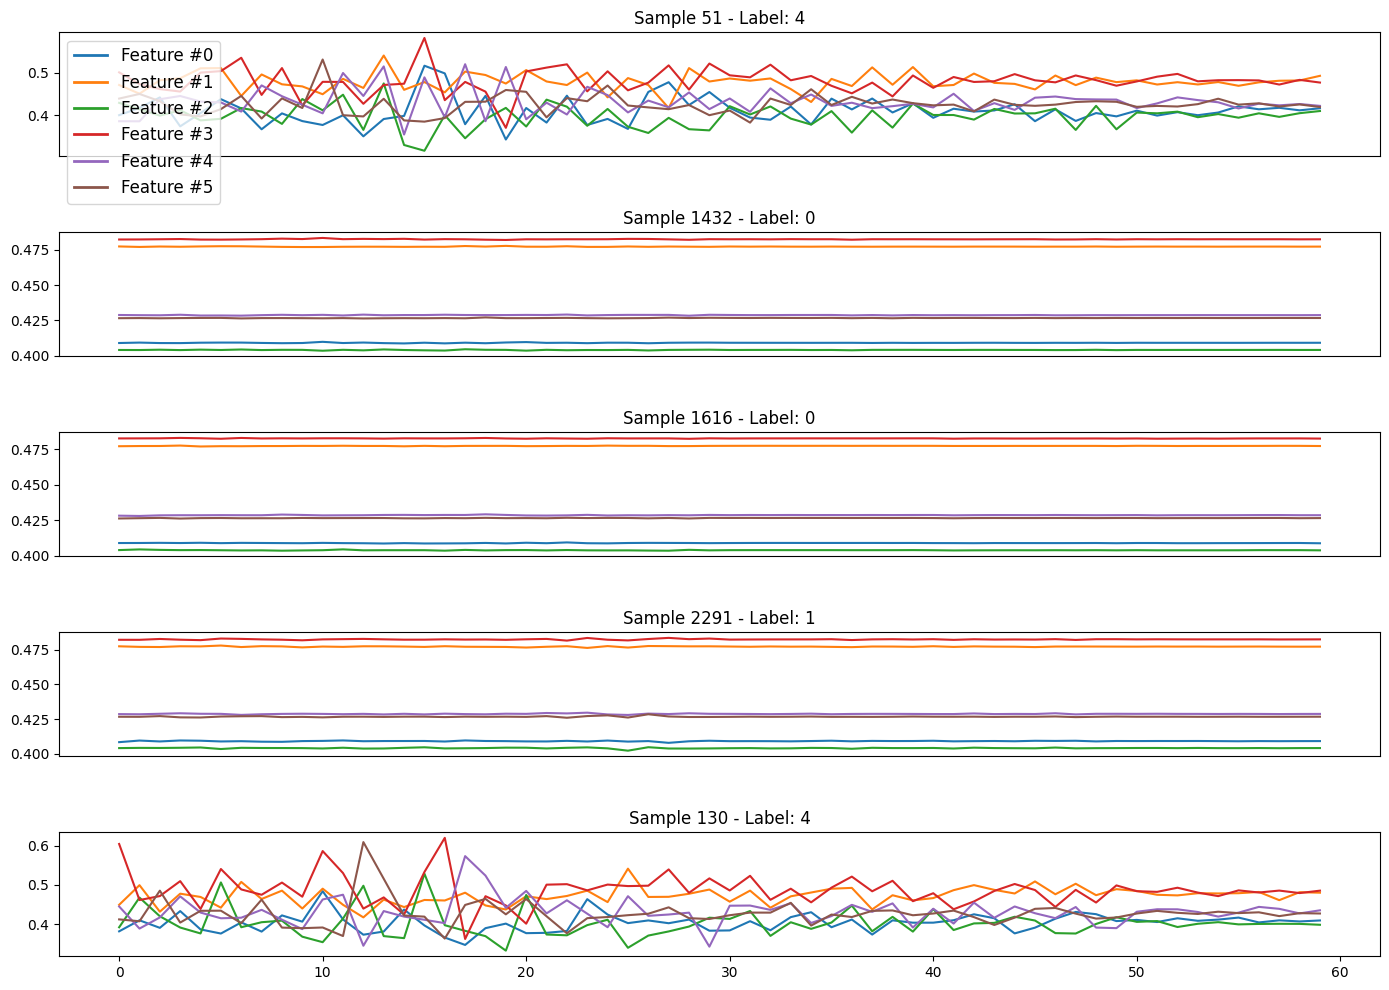

In [21]:
line_plot.visualize_ts_lineplot(X_train, y_train)


In [22]:
y_gen_labels = np.argmax(y_gen, axis=1)


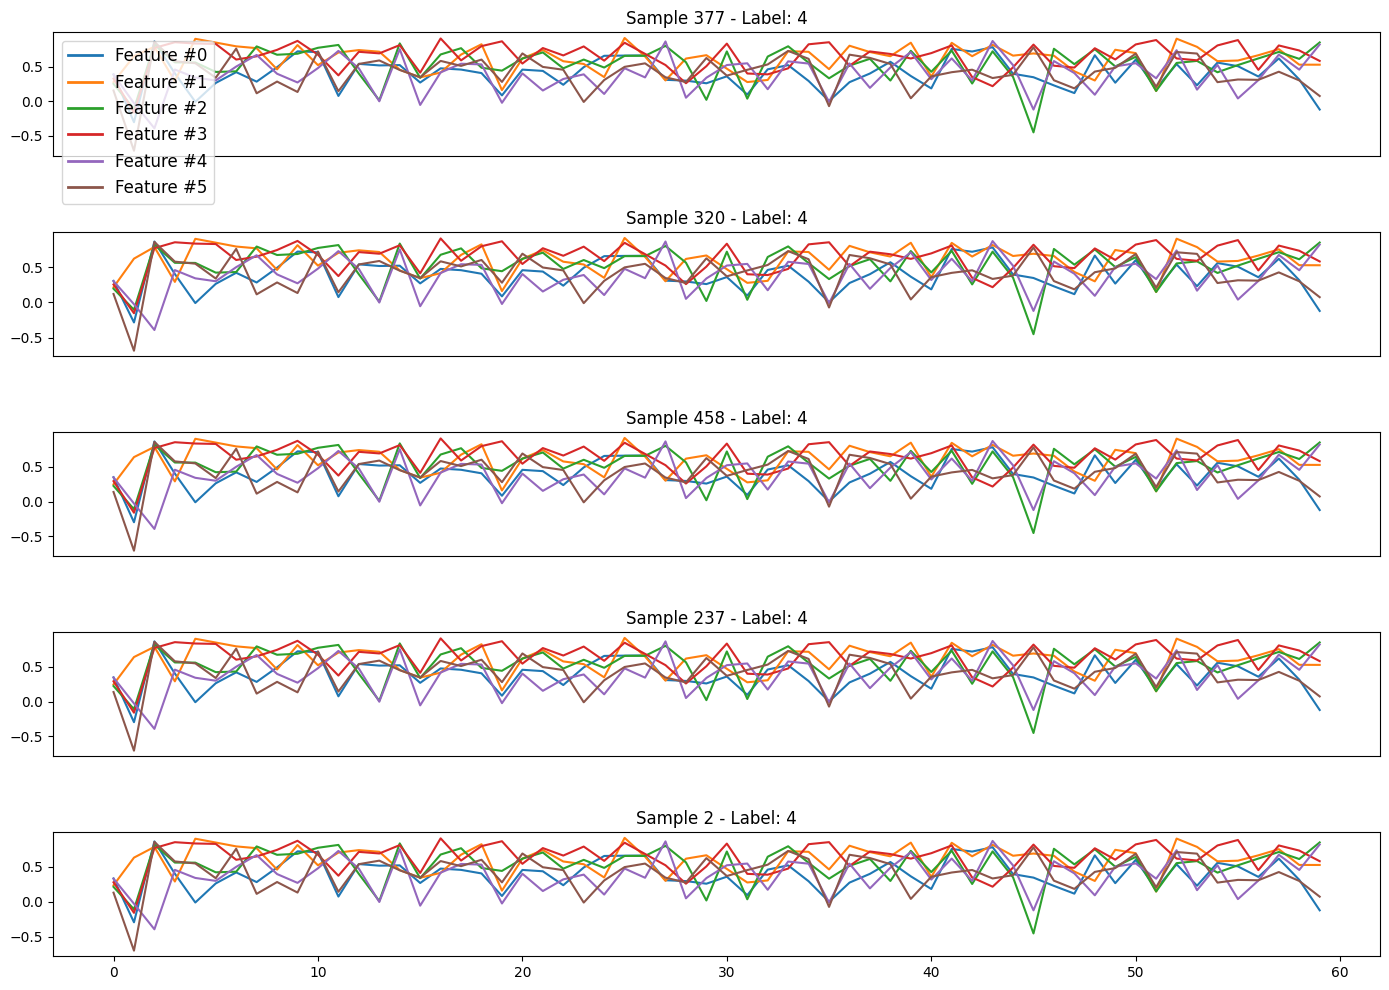

In [23]:
line_plot.visualize_ts_lineplot(X_gen, y_gen_labels)


In [24]:
#line_plot.visualize_ts_lineplot(X_gen, y)


In [25]:
X_train.shape
X_reshaped1 = X_train.reshape(X_train.shape[0], -1)
X_reshaped1.shape
X_gen_r=X_gen.reshape(X_gen.shape[0], -1)
print()

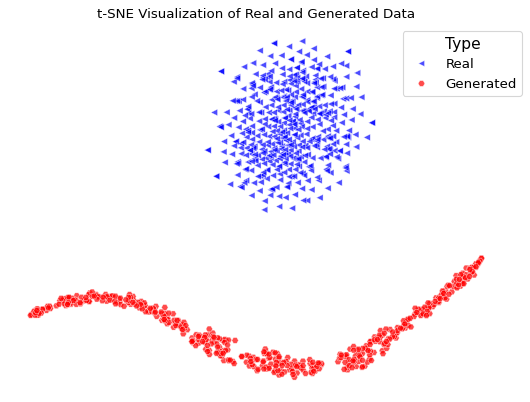

In [26]:
from src.eval.visualization import visualization_tsne_r_s 
visualization_tsne_r_s.visualize_tsne_r_s(X_train[:limit], y[:limit], X_gen, y_gen)

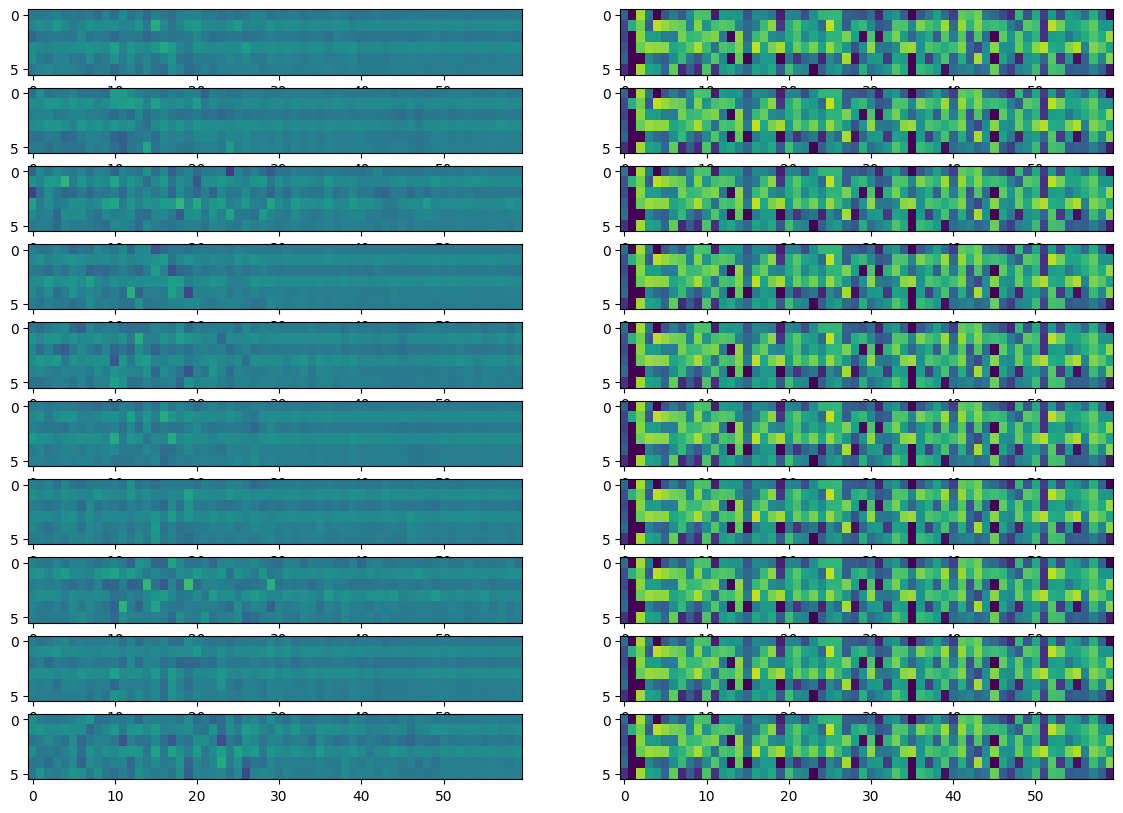

In [27]:
from src.eval.visualization import visualize_images 

visualize_images.visualize_original_and_reconst_ts(X_train[0:500], X_gen, num=10)


In [28]:
spec_entropy = tsgm.metrics.EntropyMetric()
print(spec_entropy(X_train))
print(spec_entropy(X_gen))

/HDD/dados/amparo/disciplinas/ger_ghar/GenHAR/projetos/GenHAR/venv_3.10_genHar/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 60, using nperseg = 60
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


18348.81216344693
2485.9384216012477


In [29]:
#MMD metric
#An alternative approach involves comparing synthetic and real data distributions. In this context, the use of Maximum Mean Discrepancy (MMD) [3] proves to be convenient. MMD serves as a non-parametric two-sample test to determine if samples are drawn from the same distribution. Through empirical observations, we have identified the MMD metric as a particularly convenient method for assessing the similarity of real data.#

mmd_metric = tsgm.metrics.MMDMetric()
print(mmd_metric(X_train, X_gen))

1.6598819092832855


In [30]:
n_classes=6

In [31]:
class FlattenTSOneClassSVM:
    def __init__(self, clf):
        self._clf = clf

    def fit(self, X):
        X_fl = X.reshape(X.shape[0], -1)
        self._clf.fit(X_fl)

    def predict(self, X):
        X_fl = X.reshape(X.shape[0], -1)
        return self._clf.predict(X_fl)


attacker = FlattenTSOneClassSVM(sklearn.svm.OneClassSVM())
privacy_metric = tsgm.metrics.PrivacyMembershipInferenceMetric(
    attacker=attacker
)

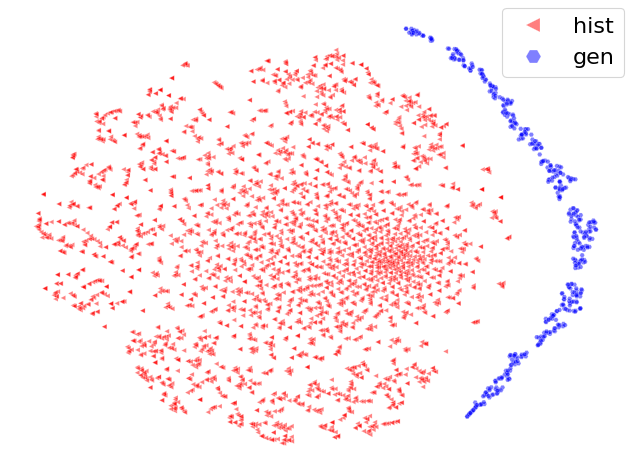

In [32]:
tsgm.utils.visualize_tsne_unlabeled(X_train, X_gen, perplexity=10, markersize=20, alpha=0.5)


In [33]:
ls

'Exploring datasets.ipynb'    plots/
 __pycache__/                 synth_data_temporal_gan.pdf
 data/                        tgsm_time_gan_har.ipynb
'exploring tansformations'/   tmp/
 exploring_models/
